In [ ]:
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
#!pip install openai
#!pip install tiktoken

In [2]:
import pandas as pd
import numpy as np
import datetime
import spacy #for text analysis
import lucem_illud #for text analysis
import collections #for counting
import re

In [3]:
#connect with drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Bo_RA/

/content/gdrive/MyDrive/Bo_RA


In [6]:
%%time
ios_df = pd.read_stata('ios_app_versions_versions_US.dta')
ios_df.head()

CPU times: user 7.46 s, sys: 12.5 s, total: 20 s
Wall time: 22.5 s


,app_id,version,description,date
0,1000017994,2.9.4,Updates in Cardiogram 2.9.4:\n• Links now open...,2018-06-28
1,1000017994,2.10.0,Updates in Cardiogram 2.10.0:\n• Stability imp...,2019-04-04
2,1000017994,3.1.8,Thanks so much for using Cardiogram!\n\nApple ...,2020-03-19
3,1000017994,3.4.0,ECG support is here. \n\nAll users with an App...,2021-03-06
4,1000017994,2.9.15,Updates in Cardiogram 2.9.15:\n• Fixes to data...,2018-11-08


In [ ]:
ios_df['version'][15] = '0.8.7' #a typo in the dataset (0.87 to 0.8.7)

In [5]:
%%time
ios_df = pd.read_pickle('ios.pickle') #if you were to read the stored data

CPU times: user 27.3 s, sys: 17.8 s, total: 45.1 s
Wall time: 46.3 s


In [101]:
ios_df.to_pickle('ios_app.pickle')

In [ ]:
#recently stored ios_app.pickle 5.22 11:23 pm

## Task 1
- At the app-month level, calculate the number of version updates for both iOs and Android apps.

In [ ]:
#aggregate observations to app-month level
ios_df['ym'] = pd.to_datetime(ios_df['date']).dt.to_period('M')
count_df = ios_df.groupby(['app_id', 'ym']).count().reset_index()[['app_id', 'ym', 'version']]
count_df = count_df.rename(columns = {'version': 'num_update'})
count_df.head()

,app_id,ym,num_update
0,1000017994,2015-08,1
1,1000017994,2015-09,1
2,1000017994,2015-11,1
3,1000017994,2015-12,2
4,1000017994,2016-01,1


To generate a complete app-month panel, I search for the earliest and the latest update date for each app, and create a list of complete year-month index, then for the months with out updates, input 0.

In [ ]:
%%time
#to generate a complete id-month panel, first create a blank dataframe of all complete id-month index
#then merge it with the previous dataframe and input 0 for months without updates
app_id_list = list(count_df['app_id'].unique()) #25728 unique app_ids
count_df_full = pd.DataFrame()
month_lst_full = []
app_id_lst_full = []
for id in app_id_list:
  min_month = min(count_df[count_df['app_id'] == id]['ym'])
  max_month = max(count_df[count_df['app_id'] == id]['ym'])
  month_lst = pd.date_range(min_month.to_timestamp(), max_month.to_timestamp() + datetime.timedelta(days=1), freq='MS').strftime("%Y-%m").tolist()                 
  month_lst_full = month_lst_full + month_lst
  app_id_lst_full = app_id_lst_full + [id]*len(month_lst)
count_df_full['app_id'] = app_id_lst_full
count_df_full['ym'] = month_lst_full

CPU times: user 42min 46s, sys: 7.36 s, total: 42min 54s
Wall time: 42min 54s


In [ ]:
count_df_full #check

,app_id,ym
0,1000017994,2015-08
1,1000017994,2015-09
2,1000017994,2015-10
3,1000017994,2015-11
4,1000017994,2015-12
...,...,...
1130499,999924447,2021-02
1130500,999924447,2021-03
1130501,999924447,2021-04
1130502,999924447,2021-05


In [ ]:
count_df_full['ym'] = count_df_full['ym'].apply(lambda x: str(x))

In [ ]:
count_df['ym'] = count_df['ym'].apply(lambda x: str(x))

In [ ]:
count_df = pd.merge(count_df, count_df_full, on = ['app_id', 'ym'], how = 'outer')
count_df = count_df.replace(np.nan, 0)
count_df

,app_id,ym,num_update
0,1000017994,2015-08,1.0
1,1000017994,2015-09,1.0
2,1000017994,2015-11,1.0
3,1000017994,2015-12,2.0
4,1000017994,2016-01,1.0
...,...,...,...
1130499,999924447,2021-01,0.0
1130500,999924447,2021-02,0.0
1130501,999924447,2021-03,0.0
1130502,999924447,2021-04,0.0


,num_update
count,1.130504e+06
mean,1.020060e+00
std,1.370931e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.700000e+01


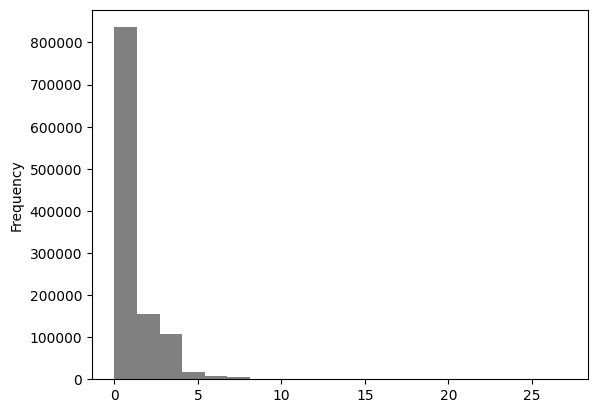

In [ ]:
count_df.to_csv('num_update_app_month.csv')
count_df['num_update'].plot.hist(bins=20, color = 'grey');
count_df.describe()

## Task 2
- At the app-update level, construct the total length of the text per version update description (drop unnecessary characters, indents, and blank spaces). Length is measured both in characters and in words.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [ ]:
ios_df['description_raw'] = ios_df['description'] #store raw description

In [ ]:
ios_df['description'] = ios_df['description'].apply(lambda x: '' if x == 'None' else x) 
# ~9000 descriptions are 'None', replace them with ''

In [22]:
def replace_itemizer(target, char_lst):
  for char in char_lst:
    if char == '\n':
      target = target.replace(char, ' ')
      #replace by blank in case there are no blanks between the the line breaker and the next word
    else:
      target = target.replace(char, '')
  return target

In [23]:
char_lst = set(['\n', '-', '•', '*', '◉', '+', '●', '>', '°', '✩', '■', '=', '▶', '◆'])
ios_df['description'] = ios_df['description'].apply(lambda x: replace_itemizer(x, char_lst)) 
#remove itemizer characters (these characters are special and cannot be removed by text normalization)

In [ ]:
%%time
ios_df['description_tk'] =  ios_df['description'].apply(lambda x: lucem_illud.word_tokenize(x)) #tokenization

CPU times: user 1h 26min 22s, sys: 20 s, total: 1h 26min 42s
Wall time: 1h 26min 30s


In [ ]:
ios_df.sort_values(['app_id'])['description_tk'].sample(20) #the tokenization went well

927013     [If, you, 've, got, your, phone, language, set...
157008     [Fixed, an, issue, causing, crashes, on, some,...
984678     [Please, note, that, in, latest, version, ther...
418548     [Ranking, League, Season, has, been, added, So...
131105     [Warlords, of, Aternum, is, an, epic, turn, ba...
94612               [Ver, 5.0.9, Updated, minor, bug, fixed]
312599     [Improved, UI, for, iPhone, X, and, higher, 19...
1010095    [Ready, for, some, good, news, from, the, Babb...
1551       [Archidon, small, speed, buff, New, and, updat...
251217     [Fixed, network, connection, errors, Added, su...
162504     [New, things, to, explore, in, Elvenar, with, ...
686226         [Update, to, improve, iOS, 14, compatibility]
599875     [IMPROVEMENTS, Additional, tutorial, steps, Ca...
370584                [Minor, bug, fixes, and, improvements]
330135     [Brand, new, Workout, Session, for, an, improv...
373497                           [trajectory, new, controls]
144324     [Version, 4.0

In [34]:
ios_df['len_word'] = ios_df['description_tk'].apply(lambda x: len(x))

In [35]:
ios_df['len_char'] = ios_df['description_tk'].apply(lambda x: len(''.join(x)))

In [36]:
ios_df['len_char_ttl'] = ios_df['description_raw'].apply(lambda x: len(x.replace('\n', ' ')))

In [37]:
ios_df[['len_word', 'len_char', 'len_char_ttl']].describe()[1:]

,len_word,len_char,len_char_ttl
mean,32.713298,162.916289,203.833262
std,46.816725,224.955897,284.035375
min,0.000000,0.000000,0.000000
25%,5.000000,34.000000,40.000000
50%,18.000000,96.000000,119.000000
75%,43.000000,212.000000,265.000000
max,773.000000,3519.000000,4000.000000


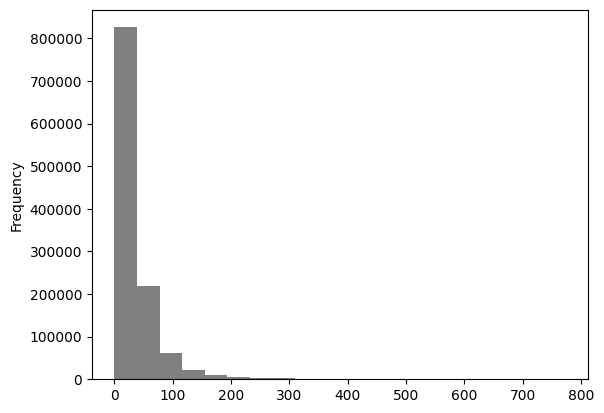

In [38]:
ios_df['len_word'].plot.hist(bins=20, color = 'grey');

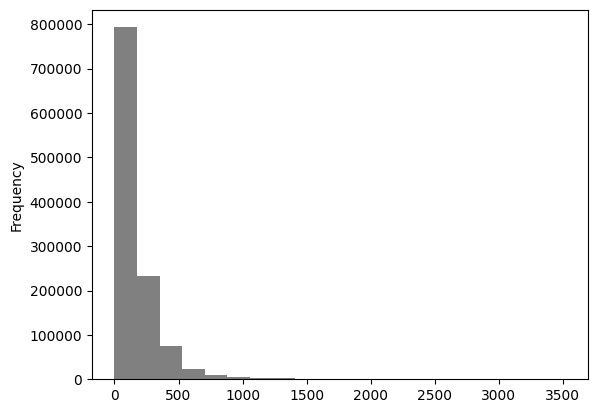

In [39]:
ios_df['len_char'].plot.hist(bins=20, color = 'grey');

To prepare for the subsequent tasks, also normalize the text (i.e., turn characters to lower cases, remove stop words, and lemmetize)

In [ ]:
def normalizeTokens(word_list, extra_stop=[]):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    #add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        #if it's not a stop word or punctuation mark, add it to the list
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            #add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
%%time
ios_df['description_nm'] =  ios_df['description'].apply(lambda x: normalizeTokens(x)) #for subsequent tasks

CPU times: user 4h 2min 53s, sys: 42.2 s, total: 4h 3min 35s
Wall time: 4h 3min 37s


In [191]:
%%time
ios_df.to_pickle('ios_app.pickle')
#[['app_id', 'version', 'date', 'description_tk', 'description_nm', 'len_word', 'len_char']]

CPU times: user 35.6 s, sys: 12.1 s, total: 47.7 s
Wall time: 56.7 s


## Task 3
- (open-ended) determine major version updates for each app. Some version update descriptions mention "major updates," while others say "minor fixes". No unified keywords indicate major version updates across all apps, so you may come up with a dictionary based on some examples. Another way to do this is that version updates from 1.1.4 to 1.2 is more likely to be major update compared to version updates from 1.1.4 to 1.1.5. You can construct multiple measures based on the version update descriptions and version codes.

### Measure 1: by version number
Reference: https://dl.acm.org/doi/abs/10.1145/2600428.2609560

In [7]:
ios_df = ios_df.sort_values(['app_id', 'date', 'version'])
ios_df['version_lag'] = ios_df.groupby('app_id').shift(1)['version']

In [124]:
def update_by_num(row):
    '''
    #1 means major revision (change of the first digit)
    #2 means minor revision (change of the second digit)
    #3 means maintanence (change of the third digit)
    #and so on
    '''
    cur_ver = row['version']#.split('.')
    lag_ver = row['version_lag']#.split('.')
    update = np.NaN
    if type(cur_ver) == str and type(lag_ver) == str:
        cur_ver = row['version'].split('.')
        lag_ver = row['version_lag'].split('.')
        cur_ver = cur_ver + ['0']*(5 - len(cur_ver)) #5 is the maximum number of version digits in the dataset
        lag_ver = lag_ver + ['0']*(5 - len(lag_ver))
        for i in range(min(len(cur_ver), len(lag_ver))):
            if cur_ver[i] != lag_ver[i]:
                update = i+1
                break 
                #add break to record the highest digit change: 
                #e.g., from 1.3 to 2.0, both the first and second digit change
                #but it is classified as major revision
    return update

In [27]:
#new
def update_distance(row):
    '''
    compute a list of distances with current and lag version number
    e.g., current ver: 2.0.0, lag ver: 1.5.4 => distance list: [1, -5, -4, 0, 0] 
    '''
    cur_ver = row['version']
    lag_ver = row['version_lag']
    dist_lst = np.NaN
    if type(cur_ver) == str and type(lag_ver) == str: #screen out non-string obs
        cur_ver = row['version'].replace('v.', '').replace('v', '') #some version number starts with v: e.g., v.2016.06.23
        lag_ver = row['version_lag'].replace('v.', '').replace('v', '')
        #print(cur_ver)
        if len(re.findall(r'[A-Za-z]', cur_ver)) == 0 and len(re.findall(r'[A-Za-z]', lag_ver)) == 0 and \
        not '(' in cur_ver and not '+' in cur_ver: 
            #screen out irregularities: some version number has alphabets and special characters in it, ignore those
            cur_ver = cur_ver.split('.')
            lag_ver = lag_ver.split('.')
            cur_ver = cur_ver + ['0']*(5 - len(cur_ver)) #5 is the maximum number of version digits in the dataset
            lag_ver = lag_ver + ['0']*(5 - len(lag_ver))
            #print(cur_ver)
            if sum([len(re.findall(r'\d+', d)) == 0 for d in cur_ver]) == 0 and \
            sum([len(re.findall(r'\d+', d)) == 0 for d in lag_ver]) == 0: 
            #screen out irregularity: e.g., "1..3.5", "임시", ignore those
                dist_lst = [int(re.findall(r'\d+', cur_ver[i])[0]) - \
                            int(re.findall(r'\d+', lag_ver[i])[0]) for i in range(len(cur_ver))]
    return dist_lst

In [10]:
def first_non_zero_dist(dist_list):
    if type(dist_list) != float:
        non_zero_dist = [d for d in dist_list if d != 0]
        if len(non_zero_dist) != 0:
            return non_zero_dist[0]
        else:
            return np.NaN
    else:
        return np.NaN

In [28]:
%%time
ios_df['dist_lst'] = ios_df.apply(update_distance, axis = 1)
#generate distance list

CPU times: user 47.5 s, sys: 1.01 s, total: 48.5 s
Wall time: 48.6 s


In [29]:
ios_df['update_num_dist'] = ios_df['dist_lst'].apply(lambda x: first_non_zero_dist(x))
#get the first non zero distance

In [30]:
ios_df['update_num_dist'].describe()[1:]

mean   -4.656551e+09
std     4.936081e+12
min    -5.232560e+15
25%     1.000000e+00
50%     1.000000e+00
75%     1.000000e+00
max     1.890200e+10
Name: update_num_dist, dtype: float64

In [31]:
print(len(ios_df[ios_df['update_num_dist'] < 0])) #2401 outliers - distance less than zero
#e.g., case 1: change of version scheme, e.g., v.2018.x.x to x.x.x; case 2: typos, e.g., 0.87 is actually 0.8.7

#ios_df[ios_df['update_num_dist'] == min(ios_df[ios_df['update_num_dist'].isna()==False]['update_num_dist'])]
#take a look at the outliers
ios_df[ios_df['update_num_dist'] < 0].sample(5)

2401


,app_id,version,description,date,description_raw,description_nm,description_tk,len_word,len_char,version_lag,update_by_num,len_char_ttl,dist_lst,update_num_dist,para,feature_score,bug_score,update_by_direct_mention
1151033,997700435,1.3,new mode! 600 puzzle levels!,2016-08-15,* New Mode! 600+ Puzzle levels!,"[new, mode, puzzle, level]","[New, Mode, 600, Puzzle, levels]",5,22,1.21,2.0,31,"[0, -18, 0, 0, 0]",-18.0,1,0.250000,0.000000,0
264694,1273108688,1.1.2,bug fix.,2018-11-11,bug fix.,"[bug, fix]","[bug, fix]",2,6,1.11,2.0,8,"[0, -10, 2, 0, 0]",-10.0,1,0.000000,1.000000,0
196565,1198232244,1.30.3,fix for app not optimising in some circumstances.,2019-01-29,Fix for app not optimising in some circumstances.,"[fix, app, optimise, circumstance]","[Fix, for, app, not, optimising, in, some, cir...",8,41,1.31.2,2.0,49,"[0, -1, 1, 0, 0]",-1.0,1,0.000000,0.500000,0
649540,1587114188,1.1.7,announcementa world map function has been adde...,2021-11-26,Announcement\nA world map function has been ad...,"[announcementa, world, map, function, add, pro...","[AnnouncementA, world, map, function, has, bee...",55,278,1.1.61,3.0,341,"[0, 0, -54, 0, 0]",-54.0,6,0.071429,0.000000,0
616773,1550833631,1.6.3072,bug fixes and optimizations.,2022-05-25,- Bug fixes and optimizations.\n,"[bug, fix, optimization]","[Bug, fixes, and, optimizations]",4,24,1.6.3686,3.0,31,"[0, 0, -614, 0, 0]",-614.0,2,0.000000,0.666667,0


In [125]:
%%time
ios_df['update_by_num'] = ios_df.apply(update_by_num, axis = 1)

CPU times: user 17.7 s, sys: 477 ms, total: 18.2 s
Wall time: 18.1 s


In [126]:
ios_df['update_by_num'].value_counts() #version update indicator by update observation

3.0    592618
2.0    469586
1.0     63174
4.0      1850
5.0       174
Name: update_by_num, dtype: int64

In [127]:
ios_df.groupby(['update_by_num', 'app_id']).count().reset_index()[['update_by_num', 'app_id']]\
.groupby('update_by_num').count() #version update indicator by app

,app_id
update_by_num,
1.0,14807
2.0,22805
3.0,19150
4.0,335
5.0,9


In [1]:
#ios_df[ios_df['update_by_num'] == 5].head() #sanity check -> there really are apps with five-digit version numbers

Modify the measure to accommondate cases where only digits at a certain location change throughout the sample period, e.g., only the third digit changes, 0.0.2 all the way to 0.0.80.

1. Calculate the maximum and minimum value of the original measure, calculate the difference
2. For apps with more than three levels of update (max_min_diff <= 2), classify updates with changes in the smallest digit major updates;
For apps with less than three levels of update, classify them based on the distance measure (distance larger than the 75 quantile)

In [26]:
min_max_num = ios_df.groupby('app_id').agg({'update_by_num': ['min', 'max']}).reset_index()
min_max_num.columns = min_max_num.columns.droplevel()
min_max_num.columns = ['app_id',"min_update_by_num","max_update_by_num"]
min_max_num['min_max_diff'] = min_max_num['max_update_by_num'] - min_max_num['min_update_by_num']
#min_max_num = min_max_num.rename(columns={'Unnamed: 0':'app_id', "min": "min_update_by_num", "max": "max_update_by_num"})
min_max_num

,app_id,min_update_by_num,max_update_by_num,min_max_diff
0,1000017994,1.0,3.0,2.0
1,1000332606,1.0,3.0,2.0
2,1000418099,2.0,3.0,1.0
3,1000556973,2.0,2.0,0.0
4,1000668798,2.0,3.0,1.0
...,...,...,...,...
25723,999637946,NaN,NaN,NaN
25724,999707163,1.0,3.0,2.0
25725,999769961,1.0,3.0,2.0
25726,999788251,2.0,3.0,1.0


In [28]:
ios_df = pd.merge(ios_df, min_max_num, on = 'app_id')

In [8]:
class Quantile:
    def __init__(self, q):
        self.q = q
        
    def __call__(self, x):
        return x.quantile(self.q)

In [30]:
dist_p75 = ios_df.groupby('app_id').agg(dist_p75 = ('update_num_dist', Quantile(0.75)))

In [33]:
ios_df = pd.merge(ios_df, dist_p75, on = 'app_id')

In [18]:
def modified_update_by_num(row):
    major = 0
    if row['min_max_diff'] >= 2 and row['update_by_num'] == row['min_update_by_num']: #digits in at least three locations change
        major = 1
    if row['min_max_diff'] == 1 and row['update_by_num'] == row['min_update_by_num'] \
    and row['update_num_dist']>row['dist_p75']: #and row['dist_p75'] > 1:
        major = 1
    if row['min_max_diff'] == 0 and row['update_num_dist']>row['dist_p75']: #and row['dist_p75'] > 1:
        major = 1
    
    return major

In [19]:
%%time
ios_df['update_by_num_modified'] = ios_df.apply(modified_update_by_num, axis = 1)

CPU times: user 19.9 s, sys: 722 ms, total: 20.6 s
Wall time: 20.6 s


In [20]:
sum(ios_df['update_by_num_modified'])

55915

In [22]:
ios_df[ios_df['update_by_num_modified'] == 1].sample(5)[['app_id', 'version', 'version_lag', 'description', 
                                                        'update_by_num', 'update_num_dist',
                                                        'dist_p75', 'min_max_diff']]#take a look

,app_id,version,version_lag,description,update_by_num,update_num_dist,dist_p75,min_max_diff
847101,511376996,1.15,1.14,chocolate and peanut butter. wine and cheese. ...,2.0,1.0,1.0,2.0
1046328,893636757,1.37,1.33,major performance enhancements side exit exha...,2.0,4.0,2.5,1.0
996621,778300400,4.0,3.8.0,new global chat and grouped chats to make the...,1.0,1.0,1.0,2.0
146358,1146717204,5.0.375,1.0.4,"new user interface: smart, fast, powerful spe...",1.0,4.0,5.0,2.0
119069,1119153393,9.0.0,8.4.0,v 9.0.0 various maintenance updates to keep th...,1.0,1.0,1.0,2.0


### Measure 2: Number of paragraphs (line breakers)
Descriptions with multiple paragraphs may involve more aspects of revision.

Classify major revisions based on quantile

In [21]:
ios_df['para'] = ios_df['description_raw'].apply(lambda x: x.count('\n')+1) #number of line breakers -> paragraphs

In [22]:
ios_df['para'].describe()[1:]

mean      3.760231
std       4.851247
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max     991.000000
Name: para, dtype: float64

In [9]:
para_p75 = ios_df.groupby('app_id').agg(para_p75 = ('para', Quantile(0.75)))

In [10]:
para_p75.describe()

,para_p75
count,25728.000000
mean,3.848317
std,3.950048
min,1.000000
25%,1.250000
50%,3.000000
75%,5.000000
max,78.500000


In [23]:
ios_df = pd.merge(ios_df, para_p75, on = 'app_id')

In [32]:
para_p90 = ios_df.groupby('app_id').agg(para_p90 = ('para', Quantile(0.9)))
ios_df = pd.merge(ios_df, para_p90, on = 'app_id')

In [126]:
para_p90.describe()

,para_p90
count,25728.000000
mean,5.369415
std,5.505113
min,1.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,93.500000


In [33]:
def update_by_para(row):
    major = 0
    if row['para']>row['para_p90']:
        major = 1
    return major

In [34]:
ios_df['update_by_para'] = ios_df.apply(update_by_para, axis=1)

In [35]:
sum(ios_df['update_by_para']) #199149 major revisions if set threshold .75 
#85152 major revisions if set threshold .9

85152

### Measure 3: revision content - feature update vs. bug fix
Revisions related to core features of the app tend to be major updates whereas revions that only involves bug fixes may be minor revisions or maintanences. 

Classify updates with feature score larger than 75 quantile and bug score smaller than 25 quantile to be major revisions.

In [191]:
feature_wds = set(['launch', 'introduce', 'feature', 'function',
                   'design', 'product', 'redesign', 'invent', 
                   'invention', 'unlock'])
bug_wds = set(['fix', 'bug', 'maintenance', 'issue', 'tweak', 
               'problem', 'outage', 'crash', 'fixed', 'bugfix', 
               'bugfixe','fixing', 'fixes', 'outage'])
#more parsimounous 

#feature_wds = set(['launch', 'introduce', 'feature', 'function',
#                   'design', 'add', 'core', 'product', 'release', 'redesign', 'invent', 
#                   'invention', 'unlock'])
#bug_wds = set(['fix', 'bug', 'maintenance', 'performance', 'optimize', 'issue', 'tweak', 
#               'optimization', 'problem', 'outage', 'crash', 'fixed', 'bugfix', 'optimise', 'bugfixe',
#               'fixing', 'fixes', 'outage', 'improve', 'improvement', 'enhance'])

In [192]:
def feature_score(word_list):
    total = len(word_list)
    feature = len([e for e in word_list if e in feature_wds])
    if total > 0:
        return feature / total
    else:
        return 0

def bug_score(word_list):
    total = len(word_list)
    bug = len([e for e in word_list if e in bug_wds])
    if total > 0:
        return bug / total
    else:
        return 0

In [194]:
ios_df['feature_score'] = ios_df['description_nm'].apply(feature_score)
ios_df['bug_score'] = ios_df['description_nm'].apply(bug_score)

In [195]:
print('number of updates related to features: {}'.format(np.shape(ios_df[ios_df['feature_score']>0])[0])) 
print('number of updates related to bugs: {}'.format(np.shape(ios_df[ios_df['bug_score']>0])[0]))
print('number of updates related to both features and bugs: {}'.format(len(ios_df.loc[(ios_df['bug_score']>0) \
                                                                                       & (ios_df['feature_score']>0)])))
ios_df[['feature_score', 'bug_score']].describe()[1:]

number of updates related to features: 199816
number of updates related to bugs: 700361
number of updates related to both features and bugs: 104572


,feature_score,bug_score
mean,0.010762,0.183746
std,0.034114,0.261894
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.066667
75%,0.000000,0.250000
max,1.000000,1.000000


In [196]:
print('number of apps with at least one update of non-zero feature score: {}'\
      .format(len(ios_df[ios_df['feature_score']>0].groupby('app_id').count())))
print('number of apps with at least one update of non-zero bug score: {}'\
      .format(len(ios_df[ios_df['bug_score']>0].groupby('app_id').count())))
print('number of apps with at least one update of non-zero bug and feature scores: {}'\
      .format(len(ios_df.loc[(ios_df['bug_score']>0)& (ios_df['feature_score']>0)].groupby('app_id').count())))

number of apps with at least one update of non-zero feature score: 15952
number of apps with at least one update of non-zero bug score: 23637
number of apps with at least one update of non-zero bug and feature scores: 12278


In [197]:
ios_df[['feature_score', 'bug_score']].corr() 
#negatively correlated

,feature_score,bug_score
feature_score,1.000000,-0.132181
bug_score,-0.132181,1.000000


In [199]:
%%time
feature_q = \
ios_df.groupby('app_id').agg(feature_p75 = ('feature_score', Quantile(0.75)),
                             feature_p90 = ('feature_score', Quantile(0.90)))

CPU times: user 42.8 s, sys: 290 ms, total: 43 s
Wall time: 43.1 s


In [200]:
feature_q.describe()

,feature_p75,feature_p90
count,25728.000000,25728.000000
mean,0.008426,0.024929
std,0.027234,0.047047
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.036825
max,0.500000,0.800000


In [201]:
%%time
bug_q = \
ios_df.groupby('app_id').agg(bug_p25 = ('bug_score', Quantile(0.25)),
                             bug_p10 = ('bug_score', Quantile(0.10)))

CPU times: user 42.5 s, sys: 275 ms, total: 42.8 s
Wall time: 42.7 s


In [202]:
bug_q.describe()

,bug_p25,bug_p10
count,25728.000000,25728.000000
mean,0.070544,0.027185
std,0.152124,0.090090
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.071621,0.000000
max,1.000000,1.000000


In [215]:
ios_df = pd.merge(ios_df, feature_q, on = 'app_id')
ios_df = pd.merge(ios_df, bug_q, on = 'app_id')

In [115]:
def update_by_feature_bug(row):
    major = 0
    if (row['feature_score']> 0) and (row['feature_score']>=row['feature_p75']) and (row['bug_score']<=row['bug_p25']):
        major = 1
    return major

In [218]:
ios_df['update_by_feature_bug']=ios_df.apply(update_by_feature_bug, axis = 1)

In [38]:
len(ios_df[ios_df['update_by_feature_bug'] == 1])

56277

In [219]:
ios_df[ios_df['update_by_feature_bug'] == 1].sample(5)[['app_id', 'version', 'version_lag', 'description', 'bug_score',
                                                        'feature_score', 'update_by_feature_bug', 'update_by_num', 
                                                        'update_by_direct_mention']]#take a look

number of major update by bug and feature score: 56277


,app_id,version,version_lag,description,bug_score,feature_score,update_by_feature_bug,update_by_num,update_by_direct_mention
907329,584632814,5.28.0,5.27.0,optimized performance within the app. stay tun...,0.0,0.083333,1,2.0,0
267648,1275445927,3.0.7,3.0.3,some tasks in contracts can be replaced now\r...,0.0,0.075472,1,3.0,0
407931,1441252752,1.2,1.1.1,today we are happy to bring you new and exciti...,0.0,0.019608,1,2.0,0
364089,1400040339,3.9,3.8,minor design changes,0.0,0.333333,1,2.0,0
867560,537263603,3.2.0,3.1.2,"this holiday season, bring the fastaction fun ...",0.0,0.062500,1,2.0,0


In [18]:
ios_df = ios_df.drop(columns=['feature_p75', 'feature_p90', 'bug_p25', 'bug_p10']) #drop columns to release menmory

### Measure 4: search for words directly suggesting major vision

In [52]:
ios_df['description'] = ios_df['description'].apply(lambda x: x.lower())
major_wds = ['major update', 'big update',  'huge update', 'importnat update', 'biggest update', 'critical update',
             'major revision','big revision','huge revision','importnat revision', 'biggest revision', 'critical revision',
             'major improvement', 'big improvement', 'huge improvement','huge improvement', 'importnat improvement', 'biggest improvement', 'critical improvement',
             'major upgrade', 'big upgrade',  'huge upgrade', 'importnat upgrade', 'biggest upgrade', 'critical upgrade']

non_major_wds = [i+'s coming' for i in major_wds] + ['previous '+ i for i in major_wds] + \
                ['stay tuned for a '+ i for i in major_wds] + [i+'is coming' for i in major_wds] +\
                [i+' coming' for i in major_wds] + ['last'+i for i in major_wds]

def major_update(text):
    n = 0
    for word in major_wds:
        if word in text:
            n +=1
    for word in non_major_wds:
        if word in text:
            n -=1
    if n > 0:
        return 1
    else:
        return 0

ios_df['update_by_direct_mention'] = ios_df['description'].apply(major_update)

In [187]:
major_update('we have some big updates coming soon!') #test

0

In [53]:
ios_df['update_by_direct_mention'].value_counts()

0    1144154
1       9028
Name: update_by_direct_mention, dtype: int64

In [190]:
for i in list(ios_df[ios_df['update_by_direct_mention'] == 1].sample(n=5, random_state=1)['description']):
    print('-'*10)
    print(i)#take a look
ios_df[ios_df['update_by_direct_mention'] == 1].sample(n=5, random_state=1)[['app_id', 'version', 'version_lag', 'description', 'bug_score',
                                                        'feature_score', 'update_by_feature_bug', 'update_by_num', 
                                                        'update_by_direct_mention']]

----------
 our biggest update yet completely new app home discover games scroll to go to the next clip follow users from every clip
----------
we're tracking our own adventures now.with our latest release, you won't notice any difference in your experience, but our team has achieved a big milestone! we have updated the analytics and migrated our backend server. this means that we can look ahead and make some big improvements to the app's user experience over the next few months.together, we can keep exploring (and improving)!
----------
this is a big update with many additions!organization: folders sort your rhyme book by title name (alpha) or by date modified display rhyme book in list mode or folders modenotepad: syllable counter (free as a token of our appreciation) support for third party keyboards printing easier access to dictionary / thesaurusthe block: you can block others, they won’t be able to see your rhymes, comments, etc. and vice versa follower notifications (when you pu

,app_id,version,version_lag,description,bug_score,feature_score,update_by_feature_bug,update_by_num,update_by_direct_mention
247646,1254530067,4.4.9,4.4.0,our biggest update yet completely new app hom...,0.000000,0.000000,0,3.0,1
856005,522990206,7.10.0,7.9.0,we're tracking our own adventures now.with our...,0.000000,0.034483,0,2.0,1
1003090,796584182,2.1,2.0.5,this is a big update with many additions!organ...,0.009434,0.000000,0,2.0,1
226174,1229012980,5.4,5.3,major update ai avatar maker added,0.000000,0.000000,0,2.0,1
700677,325525543,13.2.1,13.2.0,"now you can send gifts with your cards! plus, ...",0.000000,0.052632,0,3.0,1


### Putting it all together

In [54]:
ios_df[['update_by_num_modified', 'update_by_para', 
        'update_by_feature_bug', 'update_by_direct_mention']].corr() #slightly positively correlated

,update_by_num_modified,update_by_para,update_by_feature_bug,update_by_direct_mention
update_by_num_modified,1.000000,0.060952,0.055002,0.039406
update_by_para,0.060952,1.000000,0.043840,0.078122
update_by_feature_bug,0.055002,0.043840,1.000000,0.026278
update_by_direct_mention,0.039406,0.078122,0.026278,1.000000


In [112]:
temp_lst = []
for i in ['update_by_direct_mention', 'update_by_num_modified', 'update_by_para', 'update_by_feature_bug']:
    for j in ['update_by_direct_mention', 'update_by_num_modified', 'update_by_para', 'update_by_feature_bug']:
        if j not in temp_lst:
            if i == j:
                print('number of major revision identified by {}: {}'.format(i, len(ios_df.loc[(ios_df[i]==1)&(ios_df[j]==1)])))
            else:
                print('number of major revision identified by both {} and {}: {}'.format(i, j, len(ios_df.loc[(ios_df[i]==1)&(ios_df[j]==1)])))
            temp_lst.append(i)

number of major revision identified by update_by_direct_mention: 9028
number of major revision identified by both update_by_direct_mention and update_by_num_modified: 1298
number of major revision identified by both update_by_direct_mention and update_by_para: 2743
number of major revision identified by both update_by_direct_mention and update_by_feature_bug: 1016
number of major revision identified by update_by_num_modified: 55915
number of major revision identified by both update_by_num_modified and update_by_para: 8077
number of major revision identified by both update_by_num_modified and update_by_feature_bug: 5664
number of major revision identified by update_by_para: 85152
number of major revision identified by both update_by_para and update_by_feature_bug: 7004
number of major revision identified by update_by_feature_bug: 56277


## Task 4
- (open-ended) determine the keywords for each app based on the version update descriptions. The keywords should pick up information on the functions and characteristics of the app. This may need some ML package to learn the patterns of language and is open-ended. 

In [ ]:
%%time
#first create a new df aggregate data to app level with tokenized&normalized word lists
ios_by_app = ios_df.groupby('app_id').agg({'description_nm': 'sum', 'description': 'sum'}).reset_index()

CPU times: user 6.63 s, sys: 398 ms, total: 7.03 s
Wall time: 6.98 s


In [ ]:
ios_by_app.head()

,app_id,description_nm,description
0,1000017994,"[update, cardiogram, link, open, app, see, dat...",Updates in Cardiogram 2.9.4: Links now open wi...
1,1000332606,"[add, support, ipad, prominor, bug, fix, major...",Added Support for iPad ProMinor Bug FixesMajor...
2,1000418099,"[remove, thr, reviewsbug, fix, bug, fix, minor...",Remove the THR reviewsBug fixBug fixes.minor b...
3,1000556973,"[fix, bug]",fix bug
4,1000668798,"[app, update, apple, display, apple, watch, ap...",This app has been updated by Apple to display ...


### Measure 1: word frequency

In [ ]:
update_wds = set(['fix', 'bug', 'maintenance', 'performance', 'optimize', 'optimise', 'optimization', 
                  'improve', 'improvement', 'fixed', 'remove', 'update', 'revise', 'add', 'new', 
                  'app', 'thank', 'issue', 'outage', 'crash', 'ui', 'minor', 'fixe', 'release', 
                  'fixing', 'bugfix', 'feature', 'version', 'hey', 'enjoy', 'support', 'you',
                  'upgrade', 'enhance', 'well', 'compatibility'])
ios_by_app['description_nm_1'] = ios_by_app['description_nm'].apply(lambda x: [e for e in x if e not in update_wds])

#remove commonly used words that are unrelated to functions and characteristics of the app

In [ ]:
ios_by_app['freq_wds'] = ios_by_app['description_nm_1'].apply(lambda x: \
                                                            list(dict(collections.Counter(x).most_common(20)).keys()))

In [ ]:
ios_by_app[['app_id', 'freq_wds']].sample(10) #take a look, the key words seem to pick up some feature-related information but still quite noisy

,app_id,freq_wds
9537,1445535620,"[package, time, convenience, address, stage, s..."
7263,1367428369,[]
17120,1565600312,"[listening, experience, audio, share, ux, subs..."
17491,1574301066,"[content, level, mini, game, translation, dial..."
14323,1515994805,"[game, shop, powerup, level, content, stuff, c..."
5046,1269478443,"[game, level, come, major, close, match3, anna..."
17778,1580496772,"[video, interesting, friend, create, family, a..."
19144,1613919526,"[gameplay, improvementsminor]"
2407,1141666875,"[wallpaper, live, day, user, time, friendly, s..."
18244,1590841930,"[little, overall, brand]"


In [ ]:
ios_by_app.to_pickle('keywords.pickle')


### Measure 2: ML pretrained models - text comprehension & question answering

Reference: GPT https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb

Bert https://towardsdatascience.com/machine-comprehension-with-bert-6eadf16c87c1

In [ ]:
import ast  # for converting embeddings saved as strings back to arrays
import openai  # for calling the OpenAI API
import pandas as pd  # for storing text and embeddings data
import tiktoken  # for counting tokens
from scipy import spatial  # for calculating vector similarities for search


EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
openai.api_key = input('Enter api key: ') 

In [ ]:
ios_by_app['description_nm_joined'] = ios_by_app['description_nm'].apply(lambda x: ' '.join(x))

In [ ]:
def gpt_query(input_text):
  if len(input_text) > 15000:
    input_text = input_text[:15000]#trunk the data since gpt3.5 can only handle 4097 tokens

  query = f"""Use the below text to answer the subsequent question. Answer in 50 words. 
  Do not include bug fix, app improvement, and other maintenance related revisions. If the answer cannot be found, write "I don't know."

  Article:
  \"\"\"
  {input_text}
  \"\"\"

  Question: What are the core features and characteristics of the app?"""

  response = openai.ChatCompletion.create(
      messages=[
          {'role': 'system', 'content': 'You answer questions about features and functions of the app.'},
          {'role': 'user', 'content': query},
      ],
      model=GPT_MODEL,
      temperature=0,
  )
  output = response['choices'][0]['message']['content']

  return output

In [ ]:
%%time
#try some examples
text = list(ios_by_app['description_nm_joined'])[0]
gpt_query(text)
#it works pretty well!

CPU times: user 28.3 ms, sys: 1.76 ms, total: 30.1 ms
Wall time: 2.53 s


'Cardiogram is a health and fitness app that tracks heart rate, workouts, and rest heart rate. It offers a redesign chart, pace overlay, and histogram. The app has a new feature that allows users to compare their average with runners, bikers, and couch potatoes. It also has a habit tab that helps users track their daily progress and improve their health. The app is compatible with iPhone and Apple Watch and has a native watchOS app with a heart rate graph. It also has a sleep quality metric and a revamped profile page. The app allows users to share their heart rate data with friends and family.'

In [ ]:
#The free account at OpenAI has a rate limit of 3 per min, 
#I guess I can first filter out the revisions that only talk about bugs and maintenance, 
#and then feed it into the model. 

#Or explore other pre-trained models in Huggingface

## Data Privacy Mentions

In [38]:
privacy_wds = ["data privacy", "privacy labels", "data safety",
               "info privacy", "info safty", "info protection",
               "privacy protection",  "infomation privacy", 
               "infomation safty", "infomation protection",
               "privacy label", "protect privacy", "protect personal info", 
               "protect info", "protect information", "information security",
               "info security", "info secrecy", "infomation secrecy",
               "privacy policy", "data secrecy", "data confidentiality"] 
               #may need to screen out apps particularly about cyber security in analysis

def privacy_mention(text):
  n = 0
  for word in privacy_wds:
    if word in text:
      n +=1
  if n > 0:
    return 1
  else:
    return 0

ios_df['privacy_mention'] = ios_df['description'].apply(privacy_mention)

In [39]:
ios_df['privacy_mention'].value_counts()

0    1151685
1       1497
Name: privacy_mention, dtype: int64

In [40]:
for i in list(ios_df[ios_df['privacy_mention'] == 1].sample(5)['description']):
    print('-'*10)
    print(i)

----------
due north – we’re heading to canada this month with our awesome ‘venture north’ decorations. look out for all your favorite things from north of the border.new privacy policy: we have updated our privacy policy and it is now available for you to view in the help/support section inside the app and on our website!
----------
 now there’s a shortcut to add items to your registry as you’re browsing. spend less time reading through item reviews. we’ve added ways to quickly sort and filter them to get just the info you need. we’ve made it easier to share a link to your registry with friends and family. privacy policy updates
----------
2.9.9updated privacy policy.2.9.8fixed bug where some tiles were not loading on first click.2.9.7updated support libraries.2.9.6updated discount card. minor bug fix for discount card zip code entry field.2.9.5fixed lock screen bug showing a blank screen when unlocked.updated support libraries.2.9.4enabled printing for my med list from the share butt

## OS system updates

In [100]:
#"ios upgrade", 'system-wide update', 
OS_wds = ["ios upgrade", 'ios update', 'operating system upgrade', 'operating system update', 
          "support for the new ios", "support the new ios", "support new ios", 
          'compatible with new ios', 'now compatible with', 'now support ios'] 

def system_mention(text):
  n = 0
  for word in OS_wds:
    if word in text:
      print(text)
      n +=1
  if n > 0:
    return 1
  else:
    return 0

ios_df['system_mention'] = ios_df['description'].apply(system_mention)

In [94]:
ios_df['system_mention'].value_counts()

0    1152482
1        700
Name: system_mention, dtype: int64

In [96]:
for i in list(ios_df[ios_df['system_mention'] == 1].sample(5)['description']):
    print('-'*10)
    print(i)

----------
in this latest version, we've made massive performance improvements and took care of a lot of your suggestions. we have a very large and very active user base. your ideas and suggestions have been amazing and provided a great foundation for all of the new features in nomo 3. we still have a ton of userrequested features to add in the next version. for now, we wanted to release this major update and get it out the door! you now have the ability to share clocks!  that's right! swipe down to the bottom of your clock to see a list of your approved accountability partners. simply toggle the switch next to their name and they'll see your clock in their sidemenu! check in  this is a new feature that has been requested a lot. each clock has a "check in" button. when you tap that button, it puts a timestamp on your clock to show that you checked it. accountability partners, who can see your clock, will be able to see when you last checked in. we recommend checking in daily, if not mu